In [1]:
import numpy as np
import scipy
from scipy import stats

import pandas as pd

import tensorflow as tf
tf.config.experimental.set_visible_devices([], 'GPU')

import tensorflow_probability as tfp

tfd = tfp.distributions

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.list_logical_devices('GPU')

[]

In [4]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


## Linear models

### Data + EDA

In [5]:
# Get penguin data
penguins = pd.read_csv('./data/penguins_size.csv')

# Drop rows with NAs
penguins = penguins.dropna(axis=0)

In [6]:
# Summary
penguins[['species', 'body_mass_g']].groupby('species').agg(['mean', 'std', 'count'])

body_mass_g                  
                  mean         std count
species                                 
Adelie     3706.164384  458.620135   146
Chinstrap  3733.088235  384.335081    68
Gentoo     5090.625000  499.759002   120

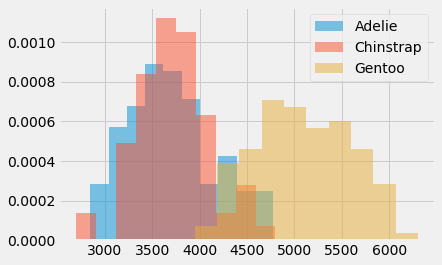

In [7]:
for species in penguins.species.unique():
    
    plt.hist(
        penguins[penguins['species'] == species]['body_mass_g'].values, 
        alpha=.5, 
        label=species,
        density=True)
    
plt.legend()
plt.show()

### Prepare the data

In [8]:
# Cast species to pd.Categorical
all_species = pd.Categorical(penguins['species'])

# Cast data to tensors
species_id = tf.constant(all_species.codes, tf.int32)
body_mass = tf.constant(penguins['body_mass_g'], tf.float32)

### Model - all species

In [17]:
# Build the model

@tfd.JointDistributionCoroutine
def penguin_mass_all_species():
    
    sigma = yield tfd.JointDistributionCoroutine.Root(
        tfd.Sample(
            tfd.HalfStudentT(
                df=100,
                loc=0,
                scale=2000),
            sample_shape=3,
            name='sigma'
        ))
    
    mu = yield tfd.JointDistributionCoroutine.Root(
        tfd.Sample(
            tfd.Normal(
                loc=4000,
                scale=3000),
            sample_shape=3,
            name='mu'
        ))
    
    mass = yield tfd.Independent(
        tfd.Normal(
            loc=tf.gather(mu, species_id, axis=-1),
            scale=tf.gather(sigma, species_id, axis=-1)),
        reinterpreted_batch_ndims=1,
        name='mass')

In [18]:
# Sample prior predictive
prior_pred_samples = penguin_mass_all_species.sample(1000)

prior_pred_samples

StructTuple(
  sigma=<tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
    array([[1709.3925  ,  358.95755 , 1215.4985  ],
           [  52.703285,   19.34111 ,  311.68253 ],
           [ 172.57379 , 4809.0786  ,  876.07556 ],
           ...,
           [2778.3271  ,  929.92584 ,  869.286   ],
           [2777.3325  ,  420.90787 , 1399.2869  ],
           [1220.576   ,  236.66171 ,  221.33643 ]], dtype=float32)>,
  mu=<tf.Tensor: shape=(1000, 3), dtype=float32, numpy=
    array([[5244.64   , 8193.17   , 1219.2451 ],
           [1292.552  , 4814.3086 ,  579.5288 ],
           [ 329.10254, 5834.6123 , 8866.42   ],
           ...,
           [ 699.5691 ,  110.49805,  784.2273 ],
           [4858.2446 , 5068.986  , 7560.641  ],
           [3277.7854 , 2210.5938 , 5070.79   ]], dtype=float32)>,
  mass=<tf.Tensor: shape=(1000, 334), dtype=float32, numpy=
    array([[ 9079.503  ,  7064.913  ,  9674.007  , ..., -1466.0356 ,
             -333.20093,  2382.8423 ],
           [ 1273.3217 ,  1297

In [19]:
# Get posterior log probs

penguin_mass_observed = penguin_mass_all_species.experimental_pin(mass=body_mass)
target_density_func = penguin_mass_all_species.log_prob

# Equivalent syntax:
# target_density_func = lambda *x: penguin_mass_all_species.log_prob(*x, mass=body_mass)

In [20]:
# Inference (MCMC)

run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts,
    autograph=False,
    jit_compile=True
)

mcmc_samples, mcmc_stats = run_mcmc(
    1000,
    penguin_mass_all_species,
    n_chains=4,
    num_adaptation_steps=1000,
    mass=body_mass
)

In [21]:
# Parse inference data
inference_data_penguins_all_mass = az.from_dict(
    
    posterior={
        k: np.swapaxes(v, 1, 0) for k, v in mcmc_samples._asdict().items()},
    
    sample_stats={
        k: np.swapaxes(mcmc_stats[k], 1, 0) for k in [
            'target_log_prob',
            'diverging',
            'accept_ratio',
            'n_steps']}
)

### Diagnose

In [22]:
az.summary(inference_data_penguins_all_mass)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],462.129,27.137,409.141,511.300,0.384,0.273,5057.0,3083.0,1.0
sigma[1],390.700,33.154,331.087,453.130,0.464,0.331,5204.0,3183.0,1.0
sigma[2],505.496,32.735,445.757,566.259,0.457,0.326,5221.0,3141.0,1.0
mu[0],3706.874,38.510,3628.939,3774.812,0.567,0.401,4616.0,3086.0,1.0
mu[1],3732.449,47.476,3643.755,3823.780,0.662,0.468,5152.0,3083.0,1.0
mu[2],5089.933,46.005,5004.286,5178.066,0.623,0.441,5481.0,3185.0,1.0


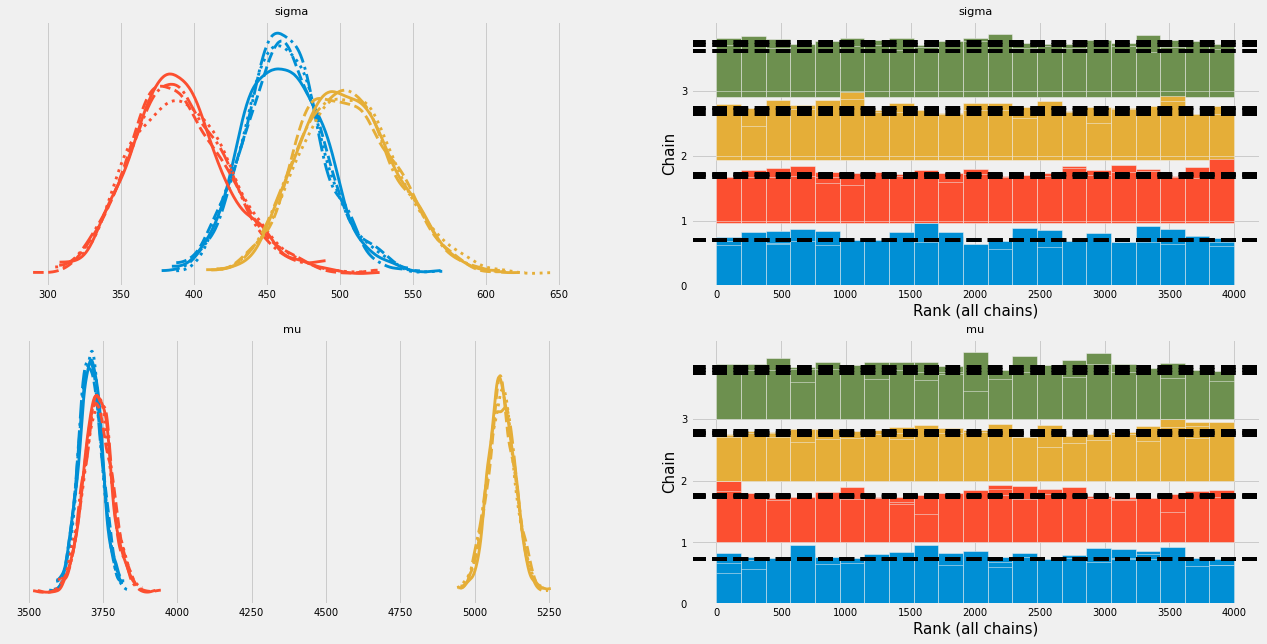

In [23]:
# Plot traces
az.plot_trace(
    inference_data_penguins_all_mass, 
    compact=True, 
    figsize=(20, 10),
    divergences="bottom", 
    kind="rank_bars")
plt.show()

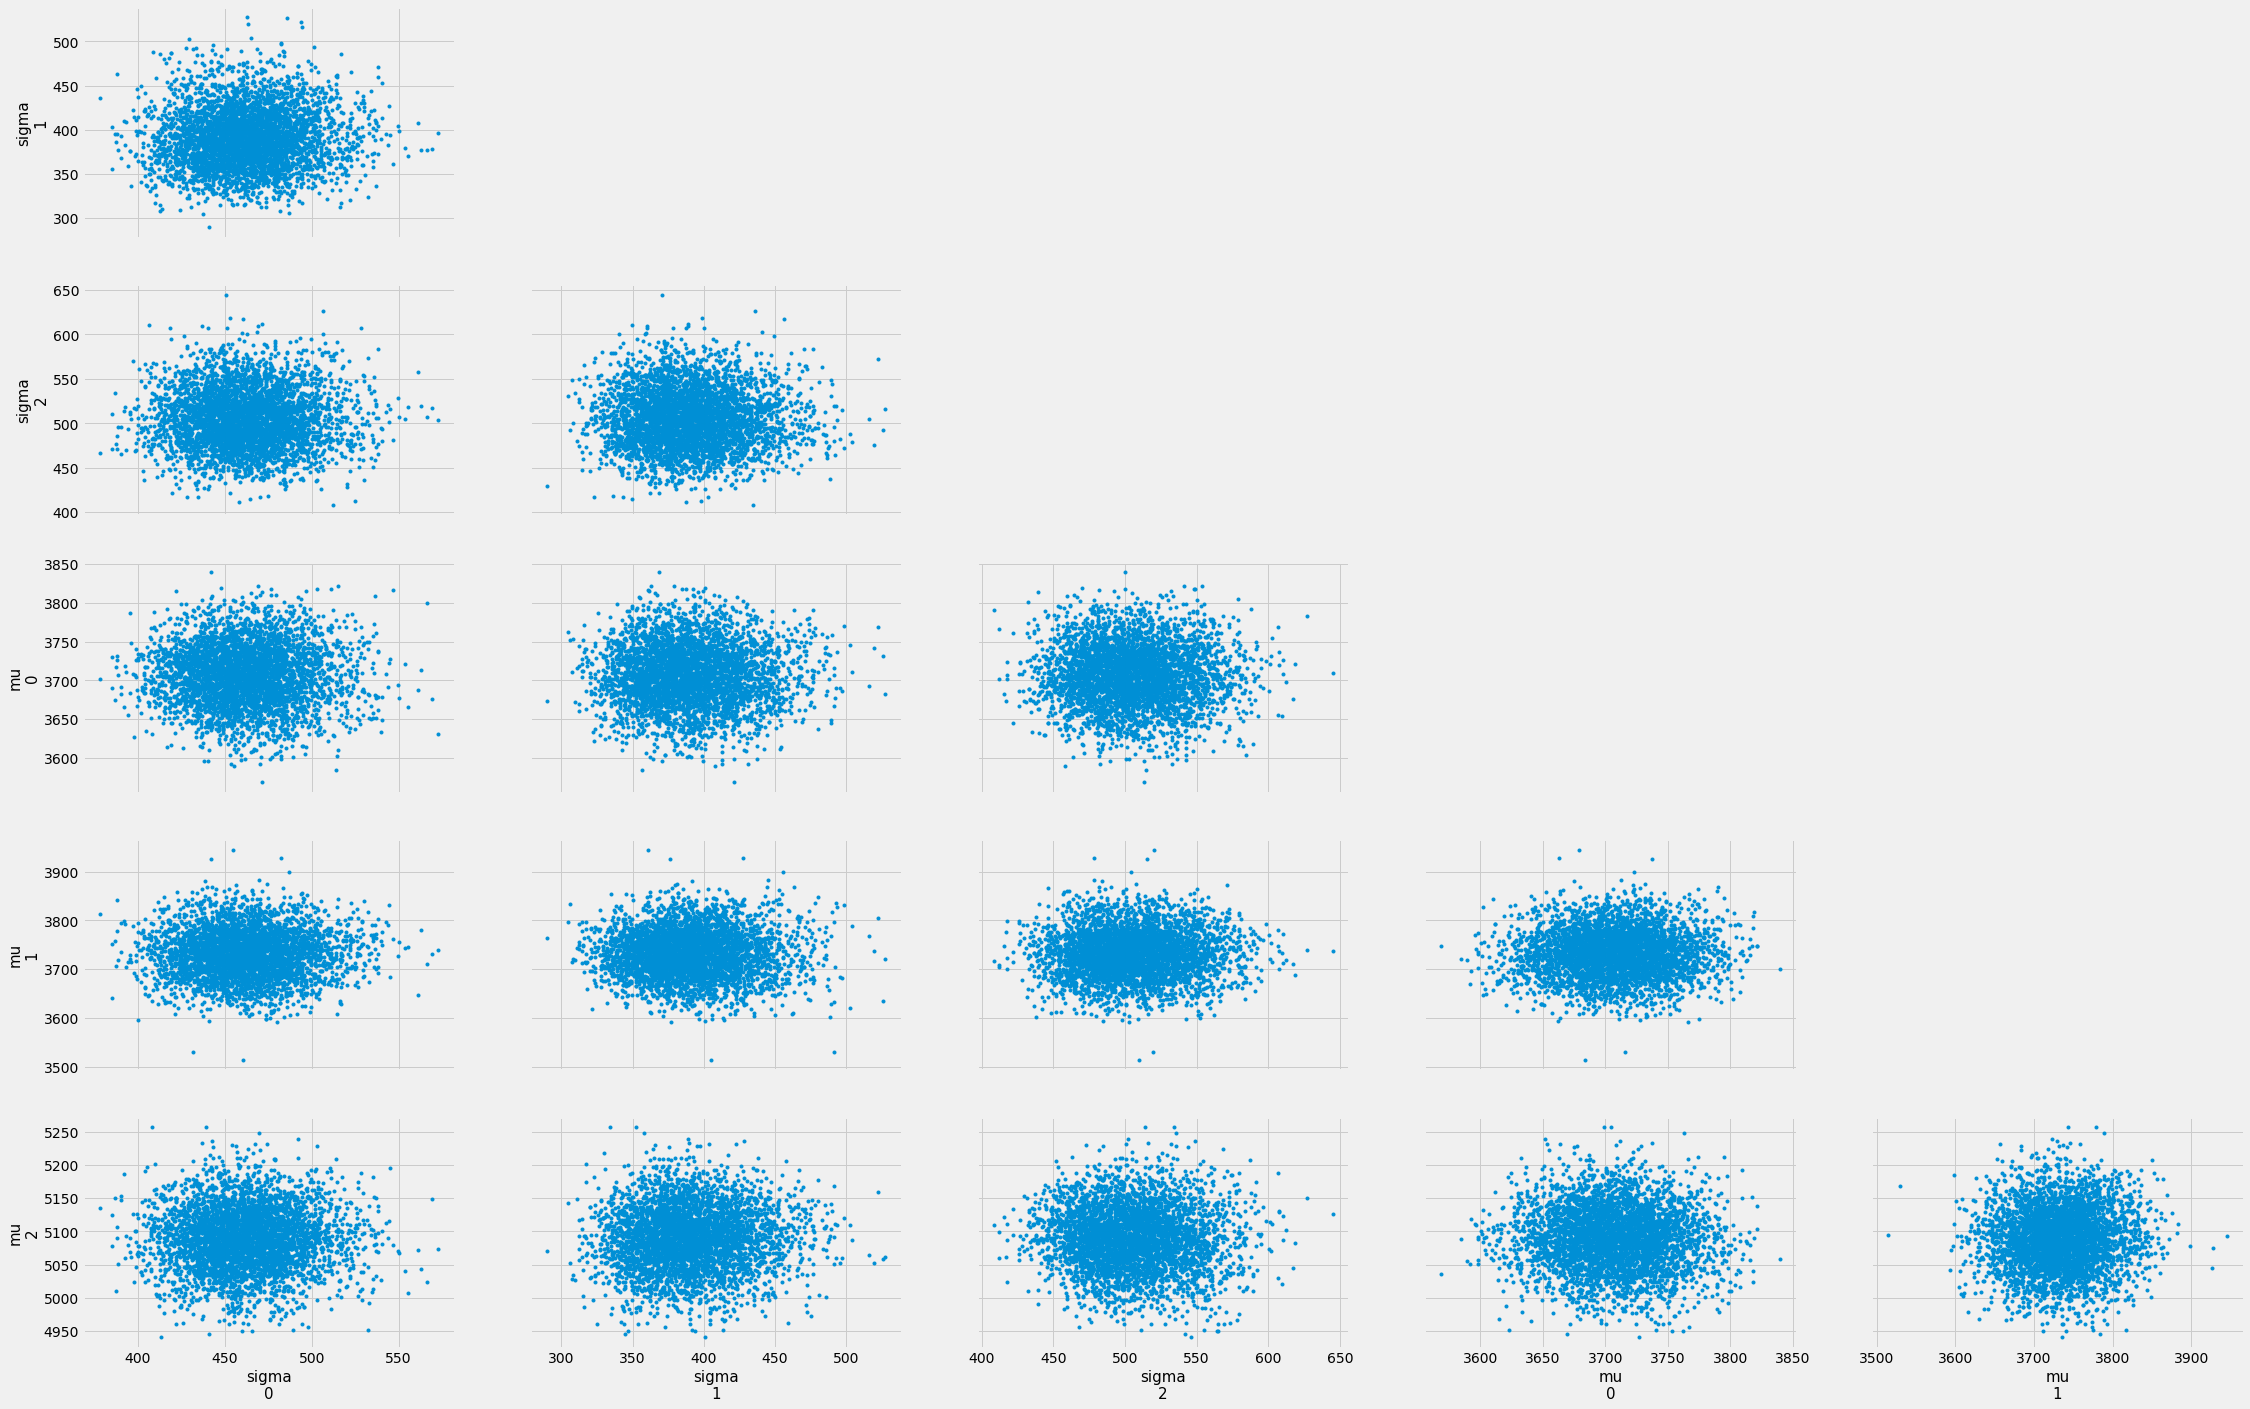

In [24]:
# Check divergences
az.plot_pair(inference_data_penguins_all_mass, divergences=True)
plt.show()

### Get prior & posterior predictive samples

In [25]:
prior_pred_samples = penguin_mass_all_species.sample([1, 1000])

distr, samples = penguin_mass_all_species.sample_distributions(
    value=mcmc_samples)

ppc_samples = samples[-1]
ppc_distr = distr[-1].distribution

data_loglik = ppc_distr.log_prob(body_mass)

In [26]:
### WARNING - RUN THIS ONLY ONCE!!! ####
inference_data_penguins_all_mass.add_groups(
    
    prior=prior_pred_samples[:-1]._asdict(),
    
    prior_predictive_samples={
        'mass': prior_pred_samples[-1]
    },
    
    posterior_predictive={
        'mass': np.swapaxes(ppc_samples, 1, 0)
    },
    
    log_likelihood={
        'mass': np.swapaxes(data_loglik, 1, 0)
    },
    
    observed_data={
        'mass': body_mass
    }
)

C:\Users\aleks\anaconda3\envs\tfp-pymc3-full\lib\site-packages\arviz\data\inference_data.py:1333: UserWarning: The group prior_predictive_samples is not defined in the InferenceData scheme
  warnings.warn(
C:\Users\aleks\anaconda3\envs\tfp-pymc3-full\lib\site-packages\arviz\data\inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


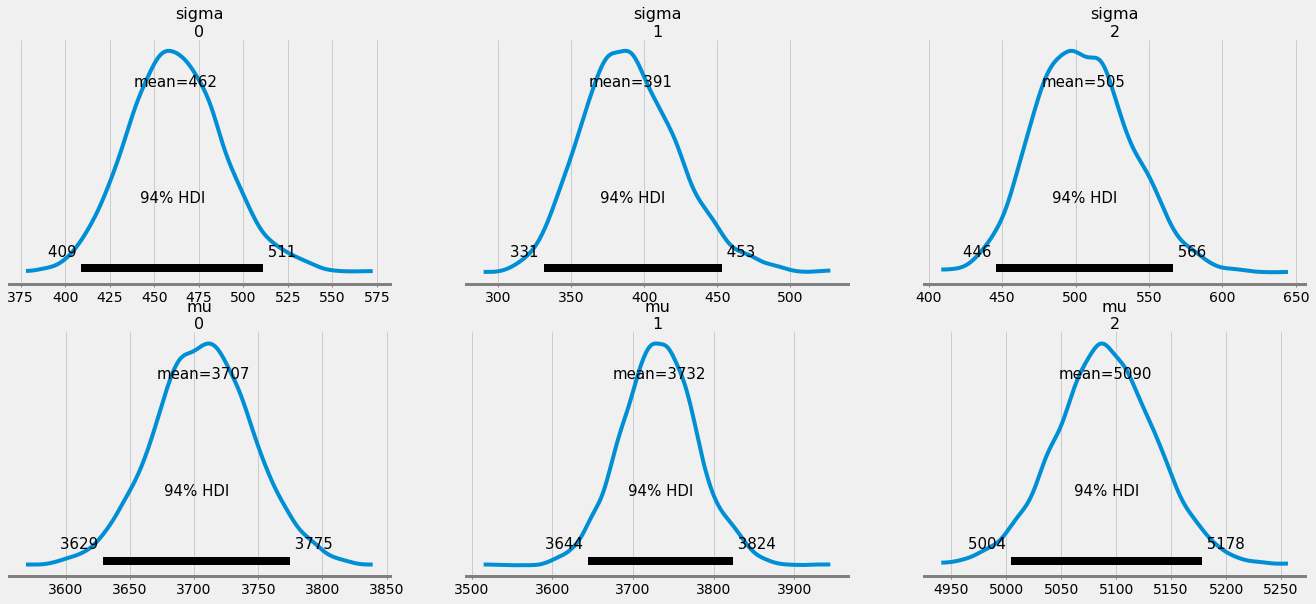

In [31]:
az.plot_posterior(
    inference_data_penguins_all_mass.posterior,
#     figsize=(15, 4),
#     var_names='mu'
)
plt.show()

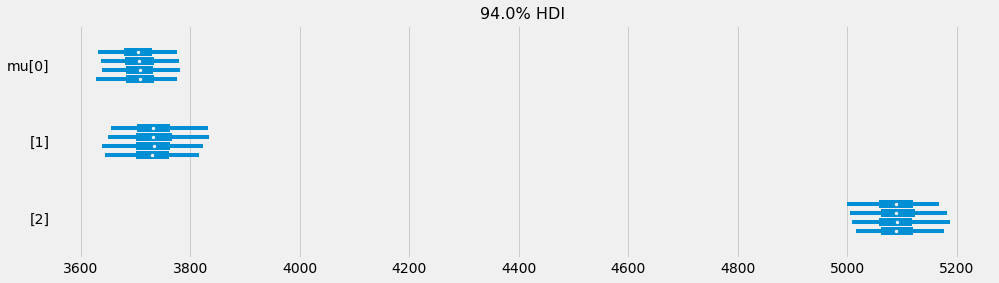

In [28]:
# Compare the species
az.plot_forest(
    inference_data_penguins_all_mass,
    figsize=(15, 4),
    var_names='mu'
)
plt.show()

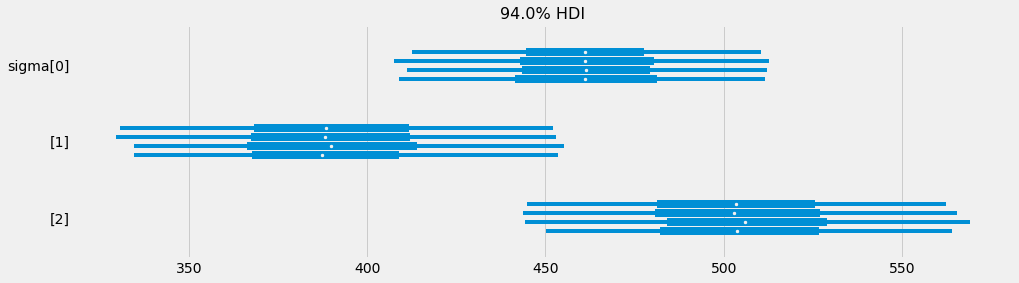

In [29]:
az.plot_forest(
    inference_data_penguins_all_mass,
    figsize=(15, 4),
    var_names='sigma'
)
plt.show()